In [31]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import cv2

In [21]:
if not os.path.exists("eagle.jpg"):
    !wget https://github.com/maki-ai/SSD-Tensorflow/raw/master/demo/eagle.jpg

In [37]:
test_image = io.imread("eagle.jpg")
plt.imshow(test_image)
plt.axis('off')

(-0.5, 772.5, 511.5, -0.5)

In [35]:
def visualize_bboxes(img, bboxes, classes):

  width, height,_ = img.shape
  print(width)
  print(height)

  for bbox_idx in range(len(bboxes)):

    bbox = bboxes[bbox_idx]
    bbox_class = classes[bbox_idx]

    color = [0,0,0]
    color[bbox_class] = 255

    top_left = (int(bbox[0]*height), int(bbox[1]*width))
    bottom_right = (int(bbox[2]*height), int(bbox[3]*width))

    cv2.rectangle(img, top_left, bottom_right, color, 2)

  plt.imshow(img)
  plt.axis("off")

In [38]:
def calc_iou(bbox1, bbox2):
    '''
    args:
      bbox1, bbox2: np arrays of bbox coordinates (top left x, top left y, bottom right x, bottom right y)
    return value:
      intersection over union [float] of the two input bboxes 
    '''

    intersection = max(0, min(bbox1[2], bbox2[2])-max(bbox1[0], bbox2[0])) * max(0, min(bbox1[3], bbox2[3])-max(bbox1[1], bbox2[1]))
    union = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1]) + (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1]) - intersection


    return intersection/union

In [40]:
def bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=.45):
    '''
    args:
        rclasses: np arrays of predicted classes
        rscores:  np arrays of predicted confidence scores
        rbboxes: np array of bboxes, coordinates: (top left x, top left y, bottom right x, bottom right y)
        nms_threshold: overlapping bbox is removed if the IoU is greater than this threshold
    return value:
        same np arrays as the input, but after non-maximum-supression
    '''

    keep_bboxes = np.ones((len(rbboxes)), dtype=np.bool)
    for reference_bbox_idx in range(len(rbboxes)):
        if keep_bboxes[reference_bbox_idx] == 1:
            for compare_bbox_idx in range(reference_bbox_idx+1, len(rbboxes)):
                if rclasses[reference_bbox_idx] == rclasses[compare_bbox_idx] and calc_iou(rbboxes[reference_bbox_idx], rbboxes[compare_bbox_idx]) > nms_threshold:
                    if rscores[reference_bbox_idx] > rscores[compare_bbox_idx]:
                        keep_bboxes[compare_bbox_idx] = 0
                    else:
                        keep_bboxes[reference_bbox_idx] = 0
                        break

    return rclasses[keep_bboxes], rscores[keep_bboxes], rbboxes[keep_bboxes]


In [26]:
def calc_prec_rec(unfiltered_pred_scores,unfiltered_pred_bboxes,gt_bboxes,IoU_threshold=0.5,conf_threshold=0):
  
  unfiltered_pred_scores = np.asarray(unfiltered_pred_scores)

  # filter bboxes based on the predicted confidence
  conf_idxes = np.where(unfiltered_pred_scores > conf_threshold)
  pred_scores = unfiltered_pred_scores[conf_idxes]
  pred_bboxes = unfiltered_pred_bboxes[conf_idxes]

  TP = 0
  FP = 0
  FN = 0

  # Create logical array for predicted and ground truth bboxes. 1 means that there isn't any match between ground truth and predicted boxes
  pred_bboxes_logical = np.ones((len(pred_bboxes)),dtype=np.bool)
  gt_bboxes_logical = np.ones((len(gt_bboxes)),dtype=np.bool)

  for gt_bbox_idx,gt_bbox in enumerate(gt_bboxes):

    for pred_bbox_idx, pred_bbox in enumerate(pred_bboxes):

      if pred_bboxes_logical[pred_bbox_idx] and calc_iou(gt_bbox,pred_bbox) > IoU_threshold:
        pred_bboxes_logical[pred_bbox_idx] = 0
        gt_bboxes_logical[gt_bbox_idx] = 0
        TP+=1
        break

  FP = sum(pred_bboxes_logical)
  FN = sum(gt_bboxes_logical)

  print("TP: " + str(TP) + "\nFP: " + str(FP) + "\nFN:" + str(FN))

  precision = TP/(TP+FP) if (TP+FP)!=0 else 0
  recall = TP/(TP+FN) if (TP+FN)!=0 else 0

  print("Precision: " + str(precision) + "\nRecall: " + str(recall))

512
773


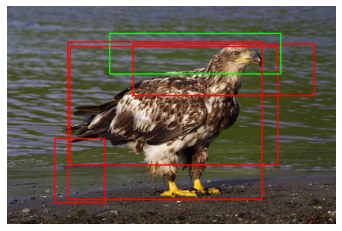

In [45]:
#def calc_prec_rec(pred_scores,pred_bboxes,gt_bboxes):

IoU_threshold = 0.5

TP = 0
FP = 0
FN = 0

pred_classes = [0,0,0,1,0]


pred_bboxes = [[0.192, 0.187, 0.824, 0.729 ],
 [0.145, 0.608, 0.298, 0.902],
 [0.384, 0.175, 0.934, 0.412 ],
 [0.313, 0.125, 0.832, 0.311],
 [0.185, 0.166, 0.775, 0.888]]


gt_bboxes = [[0.185, 0.166, 0.775, 0.888]]

pred_scores = [0.6204, 0.9285, 0.916, 0.656, 0.989]

test_image = io.imread("eagle.jpg")

visualize_bboxes(test_image, pred_bboxes, pred_classes)

pred_classes = np.asarray(pred_classes)
pred_bboxes = np.asarray(pred_bboxes)
gt_bboxes = np.asarray(gt_bboxes)
pred_scores = np.asarray(pred_scores)

calc_iou(pred_bboxes[0], pred_bboxes[1])
pred_classes, pred_scores, pred_boxes = bboxes_nms(rclasses=pred_classes, rscores=pred_scores, rbboxes=pred_bboxes, nms_threshold=0.01)


#calc_prec_rec(pred_scores,pred_bboxes,gt_bboxes,IoU_threshold)